# Classifying all of MNIST

Current SOA does only 2 digits, `IBM=(0,1)`, `Google=(3,6)`

In [4]:
import numpy as np
import matplotlib.pyplot as plt

import torch
from torch.autograd import Function
from torchvision import datasets, transforms
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F

import qiskit
from qiskit.visualization import *
from qiskit_aer import AerSimulator
from qiskit_machine_learning.neural_networks import EstimatorQNN
from qiskit.utils import algorithm_globals

from concurrent.futures import ThreadPoolExecutor
from qiskit.quantum_info import SparsePauliOp
import time as t

### Testing for EstimatorQNNs

In [5]:
algorithm_globals.random_seed = 42

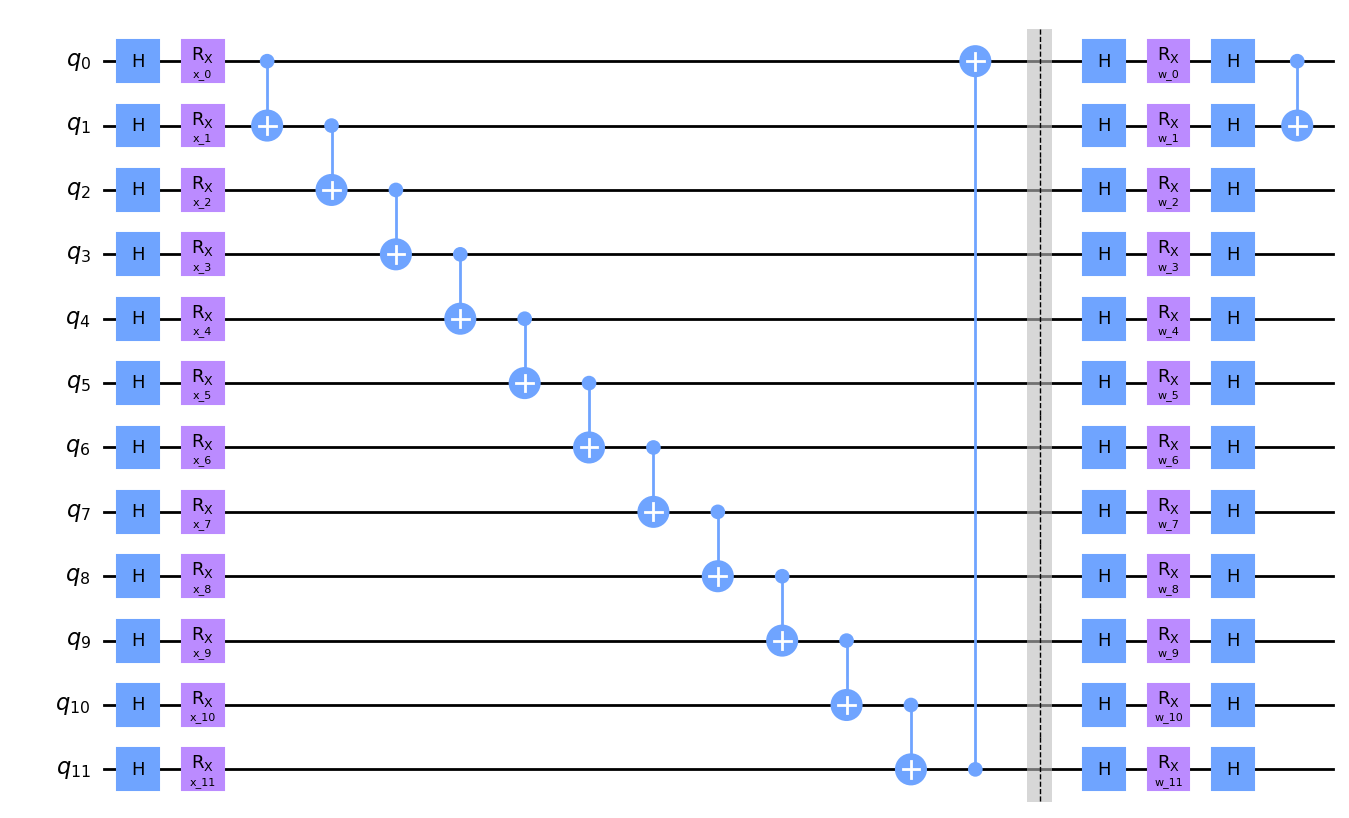

In [6]:
qubits = 12 # So that we can do 12x52 = 624

circuit = qiskit.QuantumCircuit(qubits);
all_qubits = [i for i in range(qubits)]
circuit.h(all_qubits)
# Parametrisation
inputs = [qiskit.circuit.Parameter(f'x_{i}') for i in all_qubits]
weights = [qiskit.circuit.Parameter(f'w_{i}') for i in all_qubits]

for i in all_qubits:
    circuit.rx(inputs[i], i)
for i in all_qubits:
    circuit.cx(i, ((i+1)%qubits))

circuit.barrier()

circuit.h(all_qubits)
for i in all_qubits:
    circuit.rx(weights[i], i)

circuit.h(all_qubits)
# circuit.measure_all()

circuit.cx(0,1)

circuit.draw('mpl')

from_list takes ["String:ComplexCoeff"]

Ex: $H = a Z_1X_4 + b Y_0Y_3$ -> `op = SparsePauliOp.from_list([("XIIZI", a), ("IYIIY", b)])`\
Such that string order is reverse Qubit order i.e $XIIZI$ -> the $4$th and the $1$st Qubit are $Z$ & $X$ and $3,2,0$ are $I$

Lets do a default of $H = 1*ZZZZZ$ i.e coeff is $1$

In [7]:
observables = [
    SparsePauliOp.from_list([("Z" * qubits, 1+0j)])
];
observables

[SparsePauliOp(['ZZZZZZZZZZZZ'],
               coeffs=[1.+0.j])]

In [11]:
estimator_qnn = EstimatorQNN(
    circuit=circuit, observables=observables, input_params=inputs, weight_params=weights
)
estimator_qnn

In [12]:
init_inputs = algorithm_globals.random.random(estimator_qnn.num_inputs)
init_weights = algorithm_globals.random.random(estimator_qnn.num_weights)

print(f"Number of input features for EstimatorQNN: {estimator_qnn.num_inputs} \nInput: {init_inputs}")
print(f"Number of trainable weights for EstimatorQNN: {estimator_qnn.num_weights} \nWeights: {init_weights}")

Number of input features for EstimatorQNN: 12 
Input: [0.77395605 0.43887844 0.85859792 0.69736803 0.09417735 0.97562235
 0.7611397  0.78606431 0.12811363 0.45038594 0.37079802 0.92676499]
Number of trainable weights for EstimatorQNN: 12 
Weights: [0.64386512 0.82276161 0.4434142  0.22723872 0.55458479 0.06381726
 0.82763117 0.6316644  0.75808774 0.35452597 0.97069802 0.89312112]


In [13]:
estimator_forward = estimator_qnn.forward(init_inputs, init_weights)

print(f"Forward pass result for EstimatorQNN: {estimator_forward}. \nShape: {estimator_forward.shape}")

Forward pass result for EstimatorQNN: [[9.21571847e-19]]. 
Shape: (1, 1)


In [17]:
estimator_forward_batch = estimator_qnn.forward(
    [init_inputs, init_inputs], init_weights
)

print(f"Forward pass result for EstimatorQNN: {estimator_forward_batch}.  \nShape: {estimator_forward_batch.shape}")

Forward pass result for EstimatorQNN: [[9.21571847e-19]
 [9.21571847e-19]].  
Shape: (2, 1)


In [19]:
estimator_input_grad, estimator_weight_grad = estimator_qnn.backward(
    init_inputs, init_weights
)
print(f"Input gradients for EstimatorQNN: {estimator_input_grad}.  \nShape: {estimator_input_grad}")
print(f"Weight gradients for EstimatorQNN: {estimator_weight_grad}.  \nShape: {estimator_weight_grad.shape}")

Input gradients for EstimatorQNN: None.  
Shape: None
Weight gradients for EstimatorQNN: [[[ 2.69695290e-18  2.53432258e-18  5.55653613e-19  6.50521303e-19
    2.29037709e-18 -1.89735380e-19  9.83913472e-18  2.81892565e-18
    1.39591030e-18 -8.80914265e-19  2.38524478e-18  3.97089046e-18]]].  
Shape: (1, 1, 12)


In [20]:
estimator_qnn.input_gradients = True

In [21]:
estimator_input_grad, estimator_weight_grad = estimator_qnn.backward(
    init_inputs, init_weights
)

print(f"Input gradients for EstimatorQNN: {estimator_input_grad}.  \nShape: {estimator_input_grad.shape}")
print(f"Weight gradients for EstimatorQNN: {estimator_weight_grad}.  \nShape: {estimator_weight_grad.shape}")

Input gradients for EstimatorQNN: [[[-2.00577402e-18 -5.96311195e-19 -1.62630326e-19  4.07931067e-18
    4.55364912e-18  1.08420217e-18 -4.10641573e-18  2.14129929e-18
    2.03287907e-19  4.06575815e-20 -8.26704157e-19 -7.58941521e-19]]].  
Shape: (1, 1, 12)
Weight gradients for EstimatorQNN: [[[ 2.69695290e-18  2.53432258e-18  5.55653613e-19  6.50521303e-19
    2.29037709e-18 -1.89735380e-19  9.83913472e-18  2.81892565e-18
    1.39591030e-18 -8.80914265e-19  2.38524478e-18  3.97089046e-18]]].  
Shape: (1, 1, 12)


In [12]:
observable2 = SparsePauliOp.from_list([("Z" * qc1.num_qubits, 1)])

estimator_qnn2 = EstimatorQNN(
    circuit=qc1,
    observables=[observable1, observable2],
    input_params=[params1[0]],
    weight_params=[params1[1]],
)

In [13]:
estimator_qnn_forward2 = estimator_qnn2.forward(estimator_qnn_input, estimator_qnn_weights)
estimator_qnn_input_grad2, estimator_qnn_weight_grad2 = estimator_qnn2.backward(
    estimator_qnn_input, estimator_qnn_weights
)

print(f"Forward output for EstimatorQNN1: {estimator_qnn_forward.shape}")
print(f"Forward output for EstimatorQNN2: {estimator_qnn_forward2.shape}")
print(f"Backward output for EstimatorQNN1: {estimator_qnn_weight_grad.shape}")
print(f"Backward output for EstimatorQNN2: {estimator_qnn_weight_grad2.shape}")

Forward output for EstimatorQNN1: (1, 1)
Forward output for EstimatorQNN2: (1, 2)
Backward output for EstimatorQNN1: (1, 1, 1)
Backward output for EstimatorQNN2: (1, 2, 1)


### Original Net

In [31]:
n_train = 1000;
n_test = 100; 
qubits = 13
shots = 256
threads = 8

In [32]:
X_train = datasets.MNIST(root='./data', train=True, download=True,
                         transform=transforms.Compose([transforms.ToTensor()]))

X_train.data = X_train.data[:n_train]
X_train.targets = X_train.targets[:n_train]

train_loader = torch.utils.data.DataLoader(X_train, batch_size=16, shuffle=True)

X_test = datasets.MNIST(root='./data', train=False, download=True,
                        transform=transforms.Compose([transforms.ToTensor()]))

X_test.data = X_test.data[:n_test]
X_test.targets = X_test.targets[:n_test]

test_loader = torch.utils.data.DataLoader(X_test, batch_size=1, shuffle=True)

4.3%

100.0%


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


100.0%


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw




33.8%

100.0%


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100.0%

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [33]:
def unweight(dic):
    return [k for k, v in dic.items() for i in range(v)]
    
def get_probabilities(results):

    if isinstance(results, dict):
        results = [results]

    probabilities = []
    for result in results:
        arr = np.mean([list(map(int, x)) for x in unweight(result)], axis=0)
        probabilities.append(arr)
    
    return probabilities[0] if len(probabilities)==1 else probabilities

```js
"IN IMAGE" = Conv = Conv = DropOut = Linear
||
Quantum
||
Linear = "OUTPIT"
```

In [34]:
class QuantumCircuit:
    def __init__(self, n_qubits):
        self.threads = threads;
        circs = []
        for i in range(threads): # Creates 8 parallel identical circuits
            circ = qiskit.QuantumCircuit(qubits);
            all_qubits = [i for i in range(qubits)]
            circ.h(all_qubits)
            # Parametrisation
            params = [qiskit.circuit.Parameter('theta')]
            circ.rx(params[0], all_qubits)
            # run
            circ.measure_all()
            
            param_dict = {param: np.random.random() for param in params}
            bound_circuit = circ.assign_parameters(parameters = param_dict)
            
            circs.append(bound_circuit);

        self.circuits = circs;

    def runner(self, circuit):
        # backend = qiskit.Aer.get_backend('aer_simulator')
        backend = AerSimulator()
        
        result = qiskit.execute(circuit, backend, shots=int(shots/threads)).result()
        result = get_probabilities(result.get_counts(circuit))
        return result

    def run(self, inputs):
        reses = None;
        with ThreadPoolExecutor(max_workers=len(self.circuits)) as executor:
            reses = list(executor.map(self.runner, self.circuits))

        return np.average(reses, axis=0)

In [35]:
class HybridFunction(Function):
    """ Hybrid quantum - classical function definition """

    @staticmethod  # Note: the @staticmethod decorator is not strictly necessary here
    def forward(ctx, input, quantum_circuit):
        """ Forward pass computation """
        ctx.shift = np.pi / 2;  # Store the shift value for the backward pass
        # Store the quantum circuit for the backward pass
        ctx.quantum_circuit = quantum_circuit

        results = []; 
        for i in range(len(input)):
            expectation_z = ctx.quantum_circuit.run(input[i].tolist())   
            results.append(torch.tensor(np.array([expectation_z])))

        # Save the input and the result for the backward pass
        results = torch.stack(results).squeeze(1)
        ctx.save_for_backward(input, results)

        return results

    @staticmethod
    def backward(ctx, grad_output):
        """ Backward pass computation """
        input, expectation_z = ctx.saved_tensors  # Load the saved tensors
        # Convert the input to a numpy array
        input_list = np.array(input.tolist())
        
        shift_right = input_list + np.ones(input_list.shape) * ctx.shift # Shift right
        shift_left = input_list - np.ones(input_list.shape) * ctx.shift # Shift left

        gradients = []
        for i in range(len(input_list)):
            expectation_right = ctx.quantum_circuit.run(shift_right[i]) # Run the quantum circuit for the right shift
            expectation_left = ctx.quantum_circuit.run(shift_left[i]) # Run the quantum circuit for the left shift

            gradient = torch.tensor(np.array([expectation_right])) - \
                torch.tensor(np.array([expectation_left])) # Compute the gradient
            gradients.append(gradient)
            
        # gradients = np.array([gradients]).T
        gradients = torch.stack(gradients).squeeze(1)
        return gradients * grad_output.float(), None, None

In [36]:
class Hybrid(nn.Module):
    """ Hybrid quantum - classical layer definition """

    def __init__(self):
        super(Hybrid, self).__init__()
        self.quantum_circuit = QuantumCircuit(10)

    def forward(self, input):
        return HybridFunction.apply(input, self.quantum_circuit)

In [59]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, kernel_size=4)
        self.conv2 = nn.Conv2d(6, 16, kernel_size=4)
        out_conv1 = F.max_pool2d(self.conv1(torch.rand(1,1,28,28)), 2); 
        out_conv2 = F.max_pool2d(self.conv2(out_conv1), 2)
        self.dropout = nn.Dropout2d()
        self.fc1 = nn.Linear(out_conv2.view(1,-1).shape[1], qubits)
        self.hybrid = Hybrid()
        out_hybrid = self.hybrid(torch.rand(qubits,qubits))
        self.fc2 = nn.Linear(out_hybrid.shape[1], 10)
        
#         each conv reduces size, the more the better so that we ensure that the quantum does the heavy lifting

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)
        x = self.dropout(x)
        x = x.view(x.shape[0], -1)
        x = self.fc1(x) # We don't relu this to prevent learning, we pass as-is to QC
        x = self.hybrid(x).type(torch.FloatTensor)
        x = self.fc2(x)
        return x; 
    
model = Net();
print(model)

Net(
  (conv1): Conv2d(1, 6, kernel_size=(4, 4), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(4, 4), stride=(1, 1))
  (dropout): Dropout2d(p=0.5, inplace=False)
  (fc1): Linear(in_features=256, out_features=13, bias=True)
  (hybrid): Hybrid()
  (fc2): Linear(in_features=13, out_features=10, bias=True)
)


In [66]:
optimizer = optim.Adam(model.parameters(), lr=0.001)
loss_func = nn.CrossEntropyLoss()

epochs = 20
loss_list = [3]

model.train()

outputs = []
targets = []
for epoch in range(epochs):
    total_loss = []
    times = []
    for batch_idx, (data, target) in enumerate(train_loader):
        now = t.time()
        optimizer.zero_grad()
        # Forward pass
        output = model(data)
        
        outputs.append(torch.argmax(output))
        targets.append(target)
        
        loss = loss_func(output, target) # Loss

        loss.backward() # Backward pass
        optimizer.step() # Optimize the weights
        
        total_loss.append(loss.item())
        times.append(t.time() - now)
    
    print(f"Avg Itr Time: {np.round(np.average(times),1)}s x {len(times)} itrs = {np.round(np.sum(times)/60,1)}min")
    loss_list.append(sum(total_loss)/len(total_loss))
    
    diff = np.abs(loss_list[-1] - loss_list[-2]) /loss_list[-1]; 
    if diff <= 0.001: # Early stopping criterial loss diff = 0.1%
        break;
    
    print(f'Training [{100. * (epoch + 1) / epochs:.0f}%]\tLoss: {loss_list[-1]:.4f}')

Avg Itr Time: 2.7s x 63 itrs = 2.8min
Training [5%]	Loss: 2.3009
Avg Itr Time: 2.7s x 63 itrs = 2.8min


In [75]:
for i in range(len(outputs)):
    print(outputs.shape, targets.shape)

AttributeError: 'list' object has no attribute 'shape'

Text(0, 0.5, 'CrossEntropy Loss')

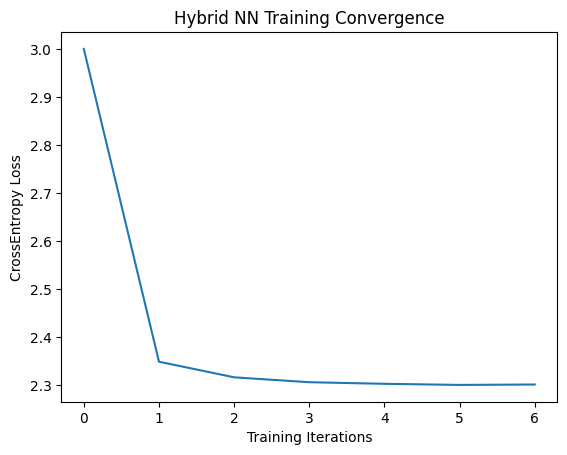

In [61]:
plt.plot(loss_list)
plt.title('Hybrid NN Training Convergence')
plt.xlabel('Training Iterations')
plt.ylabel('CrossEntropy Loss')

In [62]:
model.eval()
with torch.no_grad():
    
    correct = 0
    for batch_idx, (data, target) in enumerate(test_loader):
        output = model(data)
        
        pred = output.argmax(dim=1, keepdim=True) 
        correct += pred.eq(target.view_as(pred)).sum().item()
        
        loss = loss_func(output, target)
        total_loss.append(loss.item())
        
    print('Performance on test data:\n\tLoss: {:.4f}\n\tAccuracy: {:.1f}%'.format(
        sum(total_loss) / len(total_loss),
        correct / len(test_loader) * 100)
        )

Performance on test data:
	Loss: 2.2876
	Accuracy: 19.0%


tensor([[-0.0887,  0.1107, -0.0829, -0.0755, -0.0207, -0.0662, -0.1267,  0.1079,
         -0.1451, -0.0359]])
tensor([[-0.0696,  0.1044, -0.0589, -0.0895,  0.0236, -0.0700, -0.0917,  0.1190,
         -0.1561, -0.0507]])
tensor([[-0.0978,  0.1035, -0.0775, -0.0881,  0.0213, -0.0511, -0.0966,  0.1030,
         -0.1580, -0.0406]])
tensor([[-0.1186,  0.1369, -0.0842, -0.0989,  0.0401, -0.0667, -0.0751,  0.1127,
         -0.1776, -0.0576]])
tensor([[-0.0862,  0.1212, -0.0622, -0.1061,  0.0247, -0.0947, -0.1089,  0.1122,
         -0.1693, -0.0159]])
tensor([[-0.0986,  0.1057, -0.0859, -0.0744,  0.0236, -0.0972, -0.0760,  0.1032,
         -0.1670, -0.0472]])


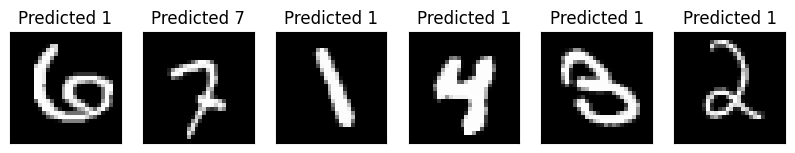

In [63]:
n_samples_show = 6
count = 0
fig, axes = plt.subplots(nrows=1, ncols=n_samples_show, figsize=(10, 3))

model.eval()
with torch.no_grad():
    for batch_idx, (data, target) in enumerate(test_loader):
        if count == n_samples_show:
            break
        output = model(data)
        print(output)
        
        pred = output.argmax(dim=1, keepdim=True) 

        axes[count].imshow(data[0].numpy().squeeze(), cmap='gray')

        axes[count].set_xticks([])
        axes[count].set_yticks([])
        axes[count].set_title('Predicted {}'.format(pred.item()))
        
        count += 1

## Experiments

In [55]:
start = t.perf_counter()
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, kernel_size=3)
        self.conv2 = nn.Conv2d(6, 16, kernel_size=3)
        out_conv1 = F.max_pool2d(self.conv1(torch.rand(1,1,28,28)), 2); 
        out_conv2 = F.max_pool2d(self.conv2(out_conv1), 2)
        
        print(out_conv2.shape)
        
        self.dropout = nn.Dropout2d()
        self.fc1 = nn.Linear(out_conv2.view(1,-1).shape[1], 10)
        
#         each conv reduces size, the more the better so that we ensure that the quantum does the heavy lifting

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)
        x = self.dropout(x)
        x = x.view(x.shape[0], -1)
        x = self.fc1(x) # We don't relu this to prevent learning, we pass as-is to QC
        return x; 
    
model = Net();

test = model(torch.randn(1,1,28,28))
diff  = t.perf_counter() - start;
print(test)
print(str(np.round(diff*100, 2)), "ms")

torch.Size([1, 16, 5, 5])
tensor([[-0.0079,  0.0523, -0.0571,  0.2836, -0.2014,  0.0532, -0.0365,  0.1164,
          0.3323,  0.0715]], grad_fn=<AddmmBackward0>)
0.38 ms


In [24]:
from IPython.core.display import HTML
HTML("""
<style>
html{filter:invert(1)}

div.prompt{opacity: 0.5;}

.btn-default{border-color: transparent;}

#header-container{display:none !important;}

div.cell.selected, div.cell.selected.jupyter-soft-selected{border-color: transparent;}
</style>
""")